In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 06: Redes neurais

**1.** O código abaixo baixa e carrega o banco de dados CIFAR10, que contém diversas imagens RGB de 10 classes distintas. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação. Também provemos um exemplo de como definir um modelo em pytorch (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação. Consulte a documentação do pytorch para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado. Além disso, mostre como os dados de entrada são transformados ao longo das camadas (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

cpu
Files already downloaded and verified
Files already downloaded and verified


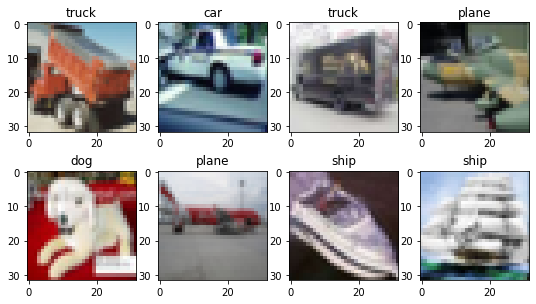

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
batch_size = 2048 

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

# split the training set into training and validation sets
train_set, val_set = random_split(train_set, [0.8, 0.2])

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i]/2 + 0.5
    npimg = npimg.numpy()
    ax[i%2,i//2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i%2,i//2].set_title(classes[labels[i]])

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.LazyLinear(120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.001)

for epoch in range(20):
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_cnn.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

c:\Users\Carol Erthal\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
f = open("results.txt", "w")
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(images)
        f.write(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')

Accuracy of the network on the test images: 54.58%


In [2]:
#conv1 -> (_ , hidden size, kernel size(menor q 10)) -> ([6, 16, 40], [3, 5, 7]])
#pool -> (kernel size, stride) de 2 a 5, variando como (x, [x-1, x]) --> ([3, 5], [[2, 3],[ 4, 5]])
#conv2 -> (_ , hidden size, kernel size(menor q 10)) -> ([16, 40], junto com o de cima)
# linear -> output size (variar 120 e 84) --> 

# 7 valores para variar

# manter epochs=30

conv1_hidden_size_list = [6, 16, 40]
conv1_kernel_size_list = [3, 5, 7]
pool_kernel_size_list = [3, 5]
pool_stride_list = [[2, 3],[ 4, 5]]
conv2_hidden_size_list = [16, 40]
linear_output_size_list = [84, 120, 240]

class CNN_2(nn.Module):
    def __init__(self, conv1_hidden_size, conv1_kernel_size, pool_kernel_size, pool_stride, conv2_hidden_size, linear_output_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, conv1_hidden_size, conv1_kernel_size)
        self.pool = nn.MaxPool2d(pool_kernel_size, pool_stride)
        self.conv2 = nn.Conv2d(conv1_hidden_size, conv2_hidden_size, conv1_kernel_size)
        self.fc1 = nn.LazyLinear(linear_output_size) 
        self.fc2 = nn.Linear(linear_output_size, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

for conv1_hidden_size in conv1_hidden_size_list:
    for conv1_kernel_size in conv1_kernel_size_list:
        for pool_kernel_size in pool_kernel_size_list:
            for pool_stride in pool_stride_list:
                for conv2_hidden_size in conv2_hidden_size_list:
                    for linear_output_size in linear_output_size_list:
                        cnn = CNN_2(conv1_hidden_size, conv1_kernel_size, pool_kernel_size, pool_stride, conv2_hidden_size, linear_output_size).to(device)
                        criterion = nn.CrossEntropyLoss()
                        optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.001)
                        for epoch in range(20):
                            for data in train_loader:
                                inputs, labels = data[0].to(device), data[1].to(device)
                                optimizer_cnn.zero_grad()
                                outputs = cnn(inputs)
                                loss = criterion(outputs, labels)
                                loss.backward()
                                optimizer_cnn.step()
                        correct = 0
                        total = 0
                        with torch.no_grad():
                            for data in test_loader:
                                images, labels = data[0].to(device), data[1].to(device)
                                outputs = cnn(images)
                                _, predicted = torch.max(outputs.data, 1)
                                total += labels.size(0)
                                correct += (predicted == labels).sum().item()
                        

NameError: name 'nn' is not defined

# Exercício de "papel e caneta"

**1.** Na aula discutimos como CNNs podem ser vistas como casos especiais de MLPs. Com isso em mente, mostre que i) camadas convolucionais podem ser escritas como uma transformação linear seguida por uma transformação não linear; e ii) camadas de pooling de média ou soma podem ser escritas como transformações lineares. 

$\textbf{Resposta:}$
I. Uma camada convolucional pode ser escrita como uma transformação linear seguida por uma transformação não linear. A transformação linear é dada, no caso bideimensional, por:

$$
S(i, j) = (X * K) (i, j) = \sum_{m} \sum_{n} X(m, n) K(i - m, j - n)
$$

onde $X$ é nossa matriz de entradas, que possui linhas $i$ e colunas $j$, e $K$ é um kernel também bidimensional. Note que podemos dizer que fazemos uma transformação linear porque estamos essencialmente combinando as entradas de $X$, nosso input, e essa relação é válida para qualquer dimensionalidade atribuida a $X$ (e consequentemente a $K$). Esse primeiro passo é chamado de operação de convolução, e seu papel é "filtrar" a entrada, fazendo um $\textit{downsample}$. A transformação não linear é dada por:

$$
\mathbf{z} = \sigma(\mathbf{y})
$$

onde $\sigma$ é a função de ativação. Em geral, utilizamos a função de ativação ReLU, e como visto acima aplicamos essa função a cada elemento da saída de da transformação linear $\mathbf{y}$. Portanto, a camada convolucional pode ser escrita como:

$$
\mathbf{z} = \sigma(S(i, j))
$$

II. Uma camada de pooling de média ou soma pode ser escrita como uma transformação linear. A transformação linear é dada por:

$$
\mathbf{y} = \mathbf{W} \mathbf{x}
$$

Portanto, a camada de pooling de média ou soma pode ser escrita dessa forma, onde $\mathbf{W}$ é a matriz de pesos e $\mathbf{x}$ é o vetor de entrada. Note que quando tratamos da média, $\mathbf{W}$ é um vetor de pesos com todos os elementos iguais a $\frac{1}{n}$, onde $n$ é o tamanho do vetor de entrada. Quando tratamos da soma, $\mathbf{W}$ é um vetor de pesos com todos os elementos iguais a $1$.



**2.** Criar modelos invariantes a transformações específicas das suas entradas é um tópico quente em machine learning. Por exemplo, suponha que queremos prever propriedades de um grafo $G$ de $n$ nós, com matriz de adjacência $A \in \{0,1\}^{n \times n}$ e em que cada nó $i=1,\ldots,n$ é anotado com um vetor de features $x_i \in \mathbb{R}^d$. Deixe ainda que $X = [x_1, \ldots, x_n]^\intercal$. Note também que um grafo com features de nó pode ser descrito como uma tupla $(X, A)$ sem perda de generalidade. Nesse caso, gostaríamos que nossa rede neural $f$ produzisse o mesmo output para grafos identicos (i.e., fosse invariante a isomorfismo). Dizemos que dois grafos $G=(X, A)$ e $G^\prime=(X^\prime, A^\prime)$ são isomorfos se existe uma matriz de permutação $P \in \{0,1\}^{n \times n} : \forall_i \sum_i P_{ij} = 1, \forall_j P_{ij} = 1 $ tal que $X^\prime = P X$ e $A^\prime = P A P^\intercal$.

Existem uma classe de redes neurais desenhadas especialmente para serem invariantes a isomorfismo: graph neural networks (GNNs). A mais famosa dessas redes é chamada graph convolutional network (GCN). O funcionamento de uma GCN de $L$ camadas para classificação de propriedades de grafos pode ser descrito como:
\begin{align}
&\hat{y} = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{(L)}_{i:}\right)\\
&H^{(\ell)} = \textrm{ReLU}(\tilde{A}H^{(\ell-1)} W^{(\ell)}) \qquad \forall \ell=1,\ldots,L\\
&H^{(0)} = X
\end{align}
onde $W^{(\ell)} \in \mathbb{R^{d_{\ell-1} \times d_{\ell}}}$ são matrizes de peso, com $d_0 = d$ e $d_L$ sendo o número de classes do nosso problema de classificação. Além disse, $\tilde{A} = D^{-1/2}(A + I)D^{-1/2}$ onde $D$ é uma matriz diagonal com $D_{ii}$ contendo o grau do nó $i$.

Prove que a GCN descrita acima produz o mesmo valor para qualquer grafo isomorfo à $G=(X, A)$.

Se você estiver interessado em aprender o básico sobre GNNs, esse vídeo é um bom começo: https://www.youtube.com/watch?v=8owQBFAHw7E (não é necessário para resolver essa questão).

Dica: Mostre antes que se $P$ é uma matriz de permutação $P^\intercal P = I$.

$\textbf{Resposta:}$

Vamos começar mostrando que $P^TP = I$. Como $P$ é uma matriz de permutação, ela é uma matriz composta por zeros com um 1 em cada linha e coluna, mas que realiza permutações porque a coluna $j$, por exemplo, tem um 1 na posição $e_{ij}$. Assim, o que $P$ faz é mover a linha $j$ para a linha $i_j$ para cada coluna $j$. $P^T$ também é uma matriz de permutação, mas o que $P^TP$ faz é mover a linha $i_j$ para a linha $j$ para cada linha $i_j$. E como essa é a operação inversa, $P^T = P^{-1}$, então $P^TP = I$.

Agora podemos avançar, lembrando que esse passo será importante posteriormente. Definimos inicialmente um grafo isomofo a $G$ como $G' = (X', A')$, onde $X' = PX$ e $A' = PAP^T$. Então, podemos reescrever o GNC:

\begin{align}
&\hat{y}' = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H'^{(L)}_{i:}\right)\\
&H'^{(\ell)} = \textrm{ReLU}(\tilde{A'}H^{(\ell-1)} W^{(\ell)}) \qquad \forall \ell=1,\ldots,L\\
&H'^{(0)} = X' = PX
\end{align}

Vamos buscar $Â'$:

\begin{align}
\tilde{A'} &= D'^{-1/2}(A' + I)D'^{-1/2}\\
&= D'^{-1/2}(PAP^T + I)D'^{-1/2}\\
&= D'^{-1/2}PAP^TD'^{-1/2} + D'^{-1/2}D'^{-1/2}\\ 
\end{align}

Note que $D' = PDP^T$, já que $D$ está sendo permutado, então:

\begin{align}
\tilde{A'} &= D'^{-1/2}PAP^TD'^{-1/2} + D'^{-1/2}D'^{-1/2}\\
&= (PD^{-1/2}P^T)PAP^T(PD^{-1/2}P^T) + (PD^{-1/2}P^T)(PD^{-1/2}P^T)\\
&= PD^{-1/2}P^TPAP^TPD^{-1/2}P^T + PD^{-1/2}P^TPD^{-1/2}P^T\\
\end{align}

Aqui, podemos usar a propriedade que mostramos no início, $P^TP = I$:

\begin{align}
\tilde{A'} &= PD^{-1/2}P^TPAP^TPD^{-1/2}P^T + PD^{-1/2}P^TPD^{-1/2}P^T\\
&=  PD^{-1/2}AD^{-1/2}P^T + PD^{-1/2}D^{-1/2}P^T\\
&=  PD^{-1/2}(A + I)D^{-1/2}P^T\\
&= P \tilde{A} P^T
\end{align}

Agora, podemos substituir $\tilde{A'}$ na equação do GNC:

\begin{align}
&\hat{y}' = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H'^{(L)}_{i:}\right)\\
&H'^{(\ell)} = \textrm{ReLU}(P \tilde{A} P^T H^{(\ell-1)} W^{(\ell)}) \qquad \forall \ell=1,\ldots,L\\
&H'^{(0)} = X' = PX
\end{align}

Nosso interesse agora é, então, pensar na próxima iteração, e ver se conseguimos chegar em $H'^{(L)}$:

\begin{align}
H'^{(1)} &= \textrm{ReLU}(P \tilde{A} P^T H^{(0)} W^{(1)})\\
&= \textrm{ReLU}(P \tilde{A} P^T PX W^{(1)})\\
&= \textrm{ReLU}(P \tilde{A} X W^{(1)})\\
&= P H^{(1)}
\end{align}

Esse processo se repete para todas as camadas, então $H'^{(L)} = P H^{(L)}$. Assim, temos:

\begin{align}
&\hat{y}' = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H'^{(L)}_{i:}\right)\\
\end{align}

E como $H'^{(L)} = P H^{(L)}$, e $P$ é uma matriz de permutação, então a soma de $H'^{(L)}_{i:}$ é igual à soma de linhas de $PH^{(L)}_{i:}$, e:

\begin{align}
\hat{y}'= \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n PH^{(L)}_{i:}\right) = \hat{y}
\end{align}

Assim, mostramos de forma genérica que produzimos o mesmo resultado para qualquer grafo isomorfo a $G$.